# Final project - Bunny ecosystem simulation

    Name: Clara Periago
    Student #: s1067476

In [15]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import jax.numpy as jnp

from pathlib import Path
import fastplotlib as fpl
import numpy as np
from pathlib import Path
from tqdm import tqdm

import seaborn as sns
import bunny, plot, grid
from result import Result

sns.set_context("talk")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# diffusion coefficients
dK = jnp.array([1.0, 0.5, 0.5])
dt = 1.
t = jnp.arange(0, 1000, dt)

# result flat, 1 bunny
r1flat = Result(
    dK,
    dt,
    max_ns=1,
    flat_terrain=True
)
# result mountain 1 bunny
r1 = Result(
    dK,
    dt,
    max_ns=1,
)
# result flat 2 bunny
r2flat = Result(
    dK,
    dt,
    flat_terrain=True
)
# result mountain 2 bunny
r2 = Result(
    dK,
    dt,
)
# result mountain 2 bunny mixed 0.05
r2mix = Result(
    dK,
    dt,
    grass_consumption=jnp.array([.5, .5]),
    mix_eps=0.05
)
# list of result, snapshot times
# how long & when to snapshot each one
#  was determined empirically with the interactive viewer
all_results = [
    (r1flat, jnp.arange(0, 250, 50)),
    r1,
    r2flat,
    r2,
    r2mix
]

In [17]:
def plot_progression(rr: Result):
    ncols = 5 if rr.mix_eps > 0. else 4
    fig, axs = plt.subplots(figsize=(8, 8), ncols=ncols, layout='constrained')
    
    rgbs, save_at = rr.print_at()
    
    i = 0
    for r, idx in zip(rgbs, save_at):
        if idx in [100, 500]: continue
        axs[i].imshow(r)
        axs[i].axis("off")
        axs[i].set_title(f"step={idx}")
        i += 1
    
    if ncols > 4:
        ax = axs[4]
        ax.imshow(rgbs[-1])
        plot.overlay_terrain_contours(rr.contours, ax, lw=.3)
        ax.axis("off")
        ax.set_title(f"step={idx}\n+terrain")
    
    
    plot.save_figure(fig, f"{rr._fmt_()}_progression")

  0%|                                                                                                                     | 0/5 [00:00<?, ?it/s]

Saving figure output to /Users/clara/uni/master/complex-adaptive-systems/project-report/img/320x320_ns=1_flat_progression


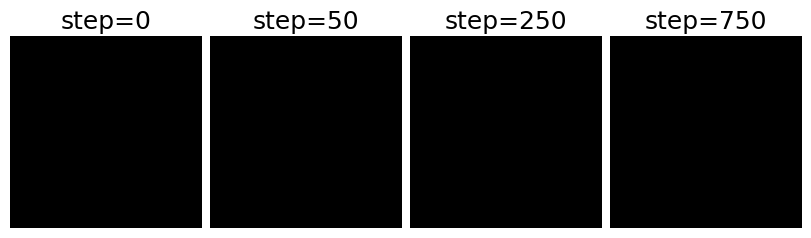

  0%|                                                                                                                     | 0/5 [00:06<?, ?it/s]


In [4]:
for rr, snaps in tqdm(all_results):
    mx = snaps[-1]
    rr.simulate(max_steps=mx)
    plot_progression(rr)
    plt.show()
    break

Saving figure output to /Users/clara/uni/master/complex-adaptive-systems/project-report/img/s0.png


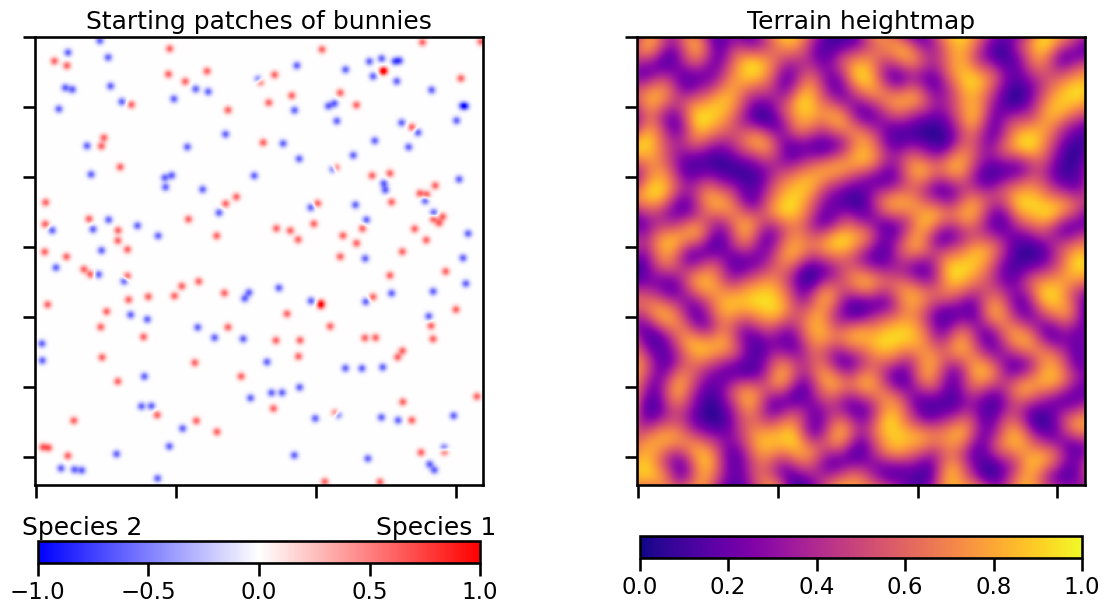

In [26]:
fig, (ax1, ax2) = plt.subplots(
    figsize=(12, 6), ncols=2,
    sharey=True,
    sharex=True,
    layout='constrained'
)

ima = ax1.imshow(r2.s0[1]-r2.s0[2], cmap='bwr', vmin=-1., vmax=1.)
cba = plt.colorbar(ima, shrink=.75, orientation="horizontal", pad=0.035)
cba.ax.text(.8, 1.6, 'Species 1', ha='center', va='center')
cba.ax.text(-.8, 1.6, 'Species 2', ha='center', va='center')
ax1.set_title('Starting patches of bunnies')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
# ax1.axis("off")

imb = ax2.imshow(r2.heightmap, cmap="plasma", vmin=0., vmax=1.)
plot.overlay_terrain_contours(rr.contours, ax2)

cbb = plt.colorbar(imb, shrink=.75, orientation="horizontal", pad=0.03)
cbb.ax.text(0., 1.5, ' ', ha='center', va='center') # otherwise the colorbars are not aligned
ax2.set_title('Terrain heightmap')
# ax2.axis("off")
plot.save_figure(fig, 's0.png')

## Interactive simulation

This was super helpful when developing, since we don't need to wait for the result of `lax.scan`. Since we don't care about intermediate values, we can just display and remove them from memory.

RFBOutputContext()

JupyterRenderCanvas(css_height='600.0px', css_width='600.0px')
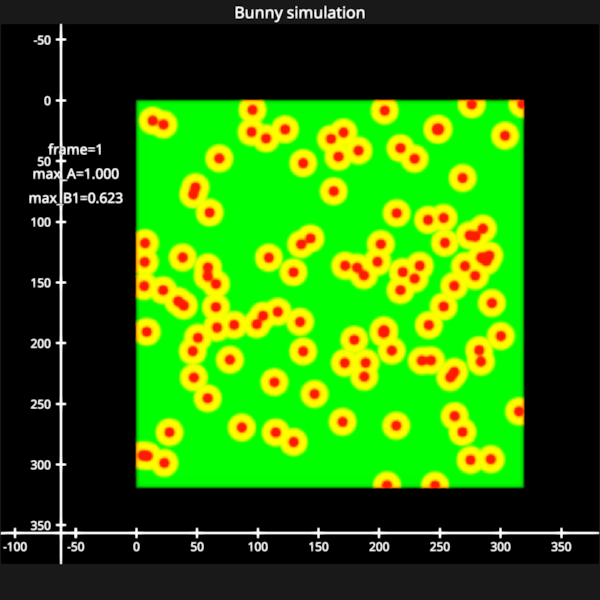

In [23]:
marker_index = 0

rr = r1flat
current_x = rr.s0

fig = fpl.Figure(size=(600, 600))
fig.canvas.max_buffered_frames = 1

fig[0, 0].title = "Bunny simulation"
lc = fig[0, 0].add_line_collection(
    data=rr.contours,
    colors=(0, 0, 0, 0.25),  # translucent black
    cmap="plasma",
    thickness=1.4,
)
lc.visible = False

data = jnp.zeros((320, 320, 3))
image = fig[0, 0].add_image(
    data=data,
    name="random-image",
    # cmap="Spectral",
    vmin=0.,
    vmax=1.,
    # offset=(0., 0., 2.),
)
cmap = plt.colormaps.get_cmap("Spectral")

fig[0, 0].add_text(text="0", name="frame", offset=(-50, 40, 0))
fig[0, 0].add_text(text="0", name="max_G", offset=(-50, 60, 0))
for i in range(rr.nS):
    fig[0, 0].add_text(text="0", name=f"max_B{i+1}", offset=(-50, 80+i*20, 0))

def update_data():
    global marker_index, current_x
    marker_index += 1

    if marker_index >= 3000:
        marker_index = 0
        current_x = rr.s0

    current_x, _ = rr.stepper(current_x)
    x = jnp.clip(current_x, 0, 1)
    grass = x[0]
    bunnies = x[1:]
    rgb = plot.render_frame(x, rr.heightmap) / 255.
    
    fig[0, 0]["random-image"].data = rgb
    fig[0, 0]["frame"].text = f"frame={marker_index}"
    fig[0, 0]["max_G"].text = f"max_A={jnp.max(grass):.3f}"
    for i in range(rr.nS):
        fig[0, 0][f"max_B{i+1}"].text = f"max_B{i+1}={jnp.max(bunnies[i]):.3f}"

@fig.renderer.add_event_handler("key_down")
def toggle(ev):
    if ev.key == "t":
        for g in fig[0, 0].graphics:
            if isinstance(g, fpl.LineGraphic) or isinstance(g, fpl.LineCollection):
                g.visible = not g.visible
    if ev.key == "s":
        tt = ['max_G', 'max_B1', 'max_B2', 'frame']
        def toggle(v):
            for g in fig[0, 0].graphics:
                print(g.name)
                if g.name in tt:
                    g.visible = v
        toggle(False)
        fig.export(f'./out/pics/{marker_index}.png')
        toggle(True)

@image.add_event_handler("pointer_down")
def click_event(ev):
    global current_x
    # get the click location in screen coordinates
    xy = (ev.x, ev.y)
    ev.stop_propagation()

    # map the screen coordinates to world coordinates
    xy = fig[0, 0].map_screen_to_world(xy)[:-1]
    y, x = jnp.array(xy, dtype=int)

    # print the click location
    ch = ev.button
    current_x = grid.draw_circle(current_x, x, y, 2, .3, channel=ch)
    print(x, y)

fig.add_animations(update_data)

# show the plot
fig.show()